## Data analysis examples

In [2]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import *

In [3]:
pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\dell\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['draw_if_interactive']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Here we'll run some example of clustering using Samsung smartphone accelerometer data to classify some basic human activities. 

In [4]:
load_ext rmagic

C:\Users\dell\Anaconda3\lib\site-packages\IPython\extensions\rmagic.py:11: UserWarning: The rmagic extension in IPython has moved to `rpy2.ipython`, please see `rpy2` documentation.
  warnings.warn("The rmagic extension in IPython has moved to "


# Read data 

In [5]:
samsungData = pd.read_csv('samsungData.csv')
samsungData = samsungData.drop(['Unnamed: 0'], axis=1)

In [5]:
samsungData.shape

(7352, 563)

Data has 7352 examples, each with 563 features

A quick look on the column names and the type of activities in the data:

In [23]:
samsungData.columns[:12]


Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X', 'tBodyAcc-max()-Y', 'tBodyAcc-max()-Z'],
      dtype='object')

In [24]:
samsungData.columns[-2:]

Index(['subject', 'activity'], dtype='object')

In [9]:
samsungData['activity'].value_counts()

laying      1407
standing    1374
sitting     1286
walk        1226
walkup      1073
walkdown     986
Name: activity, dtype: int64

The scatter plots below show the first and second variable/feature vectors for subject number 1, color coded by activity. We see that almost all activities have the first and second variable values around zero, except for LAYING, which is spread throughout the y-axis. 

In [14]:
subj1 = samsungData[samsungData['subject'] == 1]
subj1.shape

(347, 563)

# Data preprocess

In [15]:
# a simple scale function to normalize a matrix
# Normalize here means that the the mean of any feature vector is 0, and the std of any feature vector is 1. 
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

actlabels = pd.Categorical.from_array(subj1['activity']) #create panda labels for visualization

def scale(matrix):
    from numpy import mean, std
    return (matrix - mean(matrix, axis=0)) / std(matrix, axis=0)

C:\Users\dell\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: Categorical.from_array is deprecated, use Categorical instead


It is extermly important to normalize the data. Coceptually, it allows us to work with features that are unitless. That way it makes since to do algebric manipulations(such as adding/dividing/exponentiating/etc features) on the features. Empirically, this procedure gives better result.

# Data visualiztion

t-SNE: 2.7 sec


(-131.8727633226261,
 129.37064090130838,
 -165.33579117713643,
 172.09076395840697)

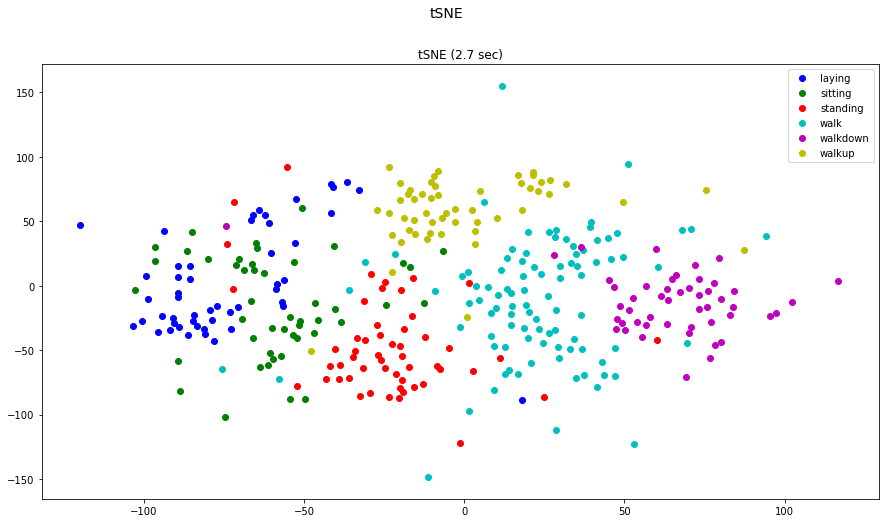

In [25]:
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

n_components = 2

t0 = time()
tsne = manifold.TSNE(n_components=n_components,early_exaggeration=100,n_iter=3000, init='pca',perplexity =10, random_state=0)
Y = tsne.fit_transform(subj1.ix[:,:-2].apply(scale)) #Create the low-dimensional embedding
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))

fig = plt.figure(figsize=(15, 8))
plt.suptitle("tSNE", fontsize=14)
ax = fig.add_subplot()
for lb, cl in zip(list(actlabels.categories), 'b g r c m y k'.split()):
    idx = (subj1['activity'] == lb)
    plt.scatter(Y[subj1.index[idx], 0], Y[subj1.index[idx], 1], c=cl, label=lb,cmap=plt.cm.Spectral)
plt.title("tSNE (%.2g sec)" % (t1 - t0))
plt.legend()
plt.axis('tight')

The TSNE algorithm did quit well! The dimensionality reduction algorithm compressed 563 to 2 features, while the notion of 'closeness' of data points makes sense. We see visually that we got some clusters according to the activity type - which makes sense.However, the result is not interpretable!

Let us continue and try to manually analyze the features.


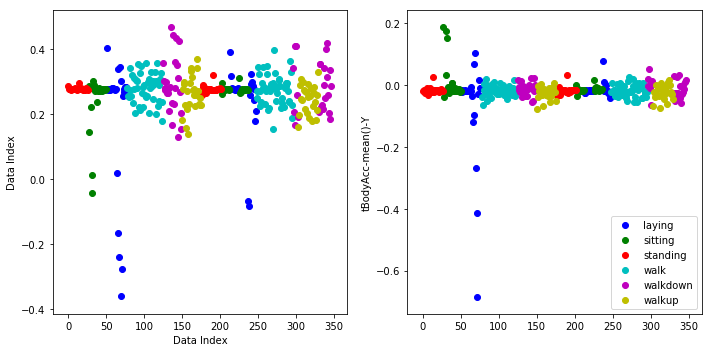

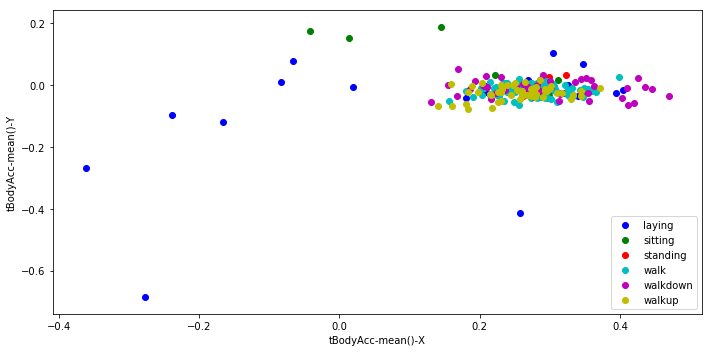

In [44]:
numericActivity = subj1.groupby('activity')

cols = {'laying' : 'b',
        'sitting' : 'g',
        'standing' : 'r',
        'walk' : 'c',
        'walkdown' : 'm',
        'walkup' : 'y'}

f, (ax1, ax2) = subplots(ncols=2)
f2, (ax3) = subplots(ncols=1)

f.set_size_inches(10, 5)
f2.set_size_inches(10, 5)

for act, df in numericActivity:
    ax1.scatter(df.index, df.ix[:,0], c=cols[act], label=act)
    ax2.scatter(df.index, df.ix[:,1], c=cols[act], label=act)
    ax3.scatter(df.ix[:,0], df.ix[:,1], c=cols[act], label=act)

ax1.set_ylabel(samsungData.columns[0])
ax1.set_xlabel('Data Index')
ax2.set_ylabel(samsungData.columns[1])
ax1.set_ylabel('Data Index')
ax2.legend(loc='lower right')
ax3.set_xlabel(samsungData.columns[0])
ax3.set_ylabel(samsungData.columns[1])
ax3.legend(loc='lower right')

f.tight_layout();
f2.tight_layout();

The conclusion from these plots is that we can't really classify the activities based on the two variables, since their values are very close to each other.

# First clustering tries

Let's run hierarchical clustering on the data, using the first three variables, which are:

In [23]:
subj1.ix[:,:3].columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z'], dtype='object')

The character 'O' (x-axis) repeated n times to encode the activities(number of O represents different activity)

C:\Users\dell\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: Categorical.from_array is deprecated, use Categorical instead


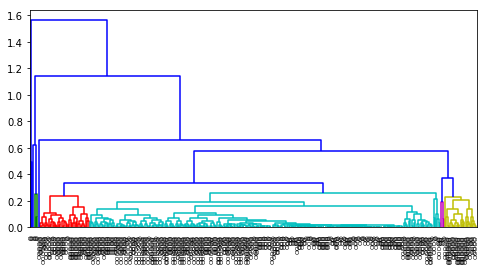

In [24]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

actlabels = pd.Categorical.from_array(subj1['activity']) #create panda labels

distanceMatrix = pdist(subj1.ix[:,:3]) #Pairwise distances between observations in n-dimensional space.
dendrogram(linkage(distanceMatrix, method='complete'), 
           color_threshold=0.3, 
           leaf_label_func=lambda x: 'O' * (actlabels.codes[x] + 1),
           leaf_font_size=6)

f = gcf()
f.set_size_inches(8, 4);

The dendrogram below again shows that there is no 'clustering' of the activities based on the used variables.

Let's see if variable number 9 and 10 could give us a better clustering(why would we expect that the maximum would contain more information about the sort of activity rather then the mean?). These are:

In [26]:
subj1.ix[:,[9, 10]].columns

Index(['tBodyAcc-max()-X', 'tBodyAcc-max()-Y'], dtype='object')

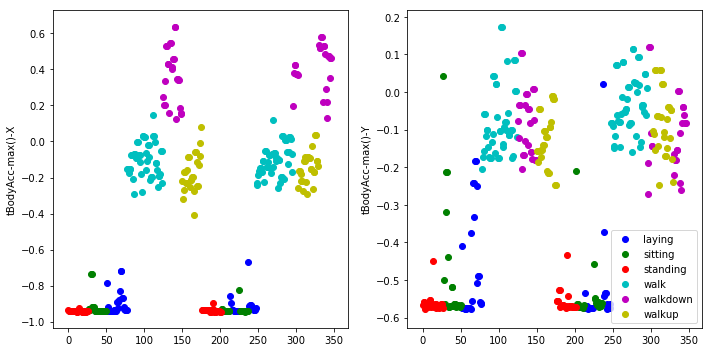

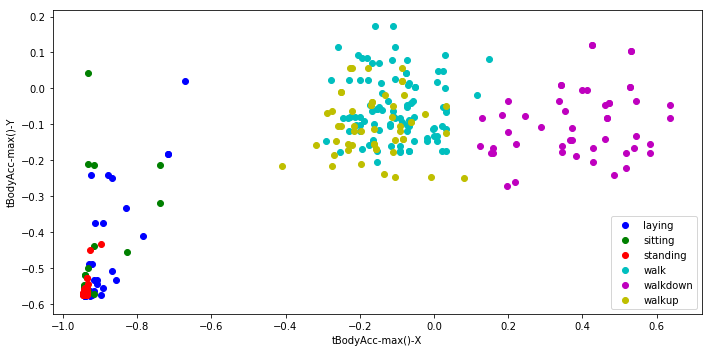

In [27]:
f, (ax1, ax2) = subplots(ncols=2)
f.set_size_inches(10, 5)
f2, (ax3) = subplots(ncols=1)
f2.set_size_inches(10, 5)

for act, df in numericActivity:
    ax1.scatter(df.index, df.ix[:,9], c=cols[act], label=act)
    ax2.scatter(df.index, df.ix[:,10], c=cols[act], label=act)
    ax3.scatter(df.ix[:,9], df.ix[:,10], c=cols[act], label=act)
    
ax1.set_ylabel(samsungData.columns[9])
ax2.set_ylabel(samsungData.columns[10])
ax3.set_xlabel(samsungData.columns[9])
ax3.set_ylabel(samsungData.columns[10])
ax2.legend(loc='lower right')
ax3.legend(loc='lower right')

f.tight_layout();
f2.tight_layout();

As we can see `tBodyAcc-max()-X` values show some grouping for WALK, WALKUP, and WALKDOWN. In particular, the variable values for activity WALKDOWN is very well separated from the others. We still can't separate WALK from WALKUP. The same also for `tBodyAcc-max()-Y`. Notice - Its is reasonable that MAX will give us a more global information, rather the mean of the measurements.

If we look at the dendrogram, taking variables number 9 to 12, we have the same conclusion as just mentioned, namely that WALKDOWN is very well separated from the others (those are labeled with 5 'O's in the horizontal axis). Yet we still can't see any groupings for other activities.

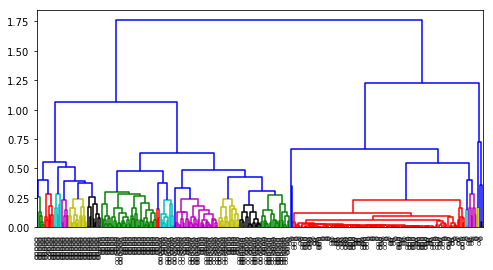

In [28]:
distanceMatrix = pdist(subj1.ix[:,9:12])
dendrogram(linkage(distanceMatrix, method='complete'), 
           color_threshold=0.3, 
           leaf_label_func=lambda x: 'O' * (actlabels.codes[x] + 1),
           leaf_font_size=6)

f = gcf()
f.set_size_inches(8, 4);

Now we'll use SVD to figure out which variables have the most importance, i.e. the ones that best separate the activities. To do this we need to normalize the matrix that contains all variable values for all observations, excluding the subject ID and the activity value. 

Such scaling functionality is actually available in `scikit-learn`, but since it's just a simple scaling that we need, we'll just define a short function to do that:

In [29]:
U, D, Vt = np.linalg.svd(subj1.ix[:,:-2].apply(scale), full_matrices=False)

If we make scatter plots of the first and the second columns of the U matrix, grouped by activities, we'll see that WALKUP is very well separated from other activities:

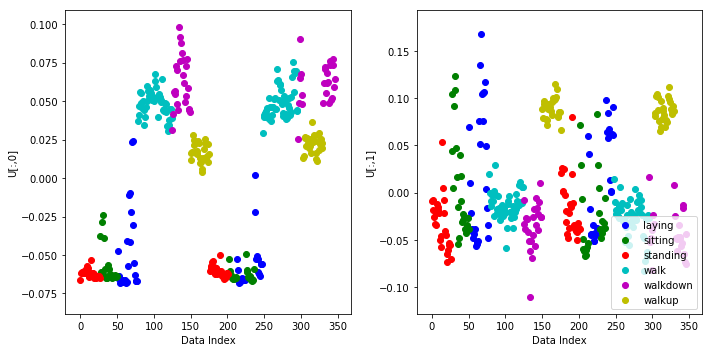

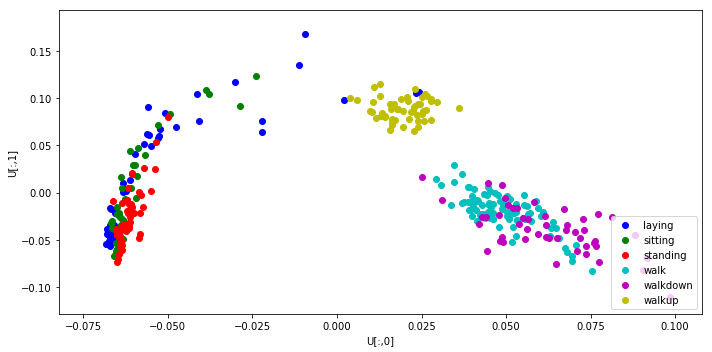

In [45]:
f, (ax1, ax2) = subplots(ncols=2)
f2, (ax3) = subplots(ncols=1)

f.set_size_inches(10, 5)
f2.set_size_inches(10, 5)

for lb, cl in zip(list(actlabels.categories), 'b g r c m y k'.split()):
    idx = (subj1['activity'] == lb)
    ax1.scatter(subj1.index[idx], U[subj1.index[idx],0], c=cl, label=lb)
    ax2.scatter(subj1.index[idx], U[subj1.index[idx],1], c=cl, label=lb)
    ax3.scatter(U[subj1.index[idx],0], U[subj1.index[idx],1], c=cl, label=lb)

    
ax1.set_ylabel('U[:,0]')
ax1.set_xlabel('Data Index')
ax2.set_ylabel('U[:,1]')
ax2.set_xlabel('Data Index')
ax3.set_xlabel('U[:,0]')
ax3.set_ylabel('U[:,1]')
ax2.legend(loc='lower right')
ax3.legend(loc='lower right')

f.tight_layout();
f2.tight_layout();

Now what we can also do, is to look for which variable that contributes most significantly for this separation. To do this, we'll look at the Vt matrix. The following steps will plot the first-row values of the Vt matrix, and get the location/index of the maximum value. This index corresponds to the variable number that best separates the WALKUP activity.

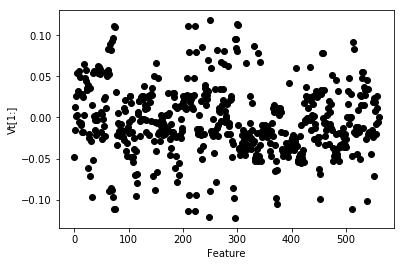

In [36]:
plt.plot(Vt[1,:], 'ok');
plt.xlabel('Feature')
plt.ylabel('Vt[1:]')

In [39]:
maxContrib = np.argmax(Vt[1,:])
maxContrib

249

If we now include this variable (i.e. number 249) hopefully we can add the separation of WALKUP to our previously obtained separation of WALKDOWN. To see it we'll compute another hierarchical cluster and plot its dendrogram:

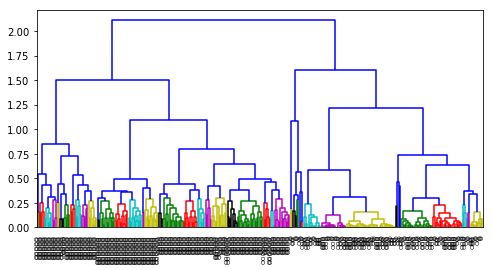

In [42]:
distanceMatrix = pdist(subj1.take([9,10,11] + [maxContrib], axis=1))
dendrogram(linkage(distanceMatrix, method='complete'), 
           color_threshold=0.3, 
           leaf_label_func=lambda x: 'O' * (actlabels.codes[x] + 1),
           leaf_font_size=6)

f = gcf()
f.set_size_inches(8, 4);

And it works! We can see now that WALKDOWN (with 6 'O's on the left hand side of the horizontal axis) is completely separated from WALK (4 'O's) and WALKUP (5 'O's). 

Since we are curious, let's check out what variable it is that separates WALKDOWN from everything else, the one that we discovered through SVD:

In [43]:
samsungData.columns[maxContrib]

'tBodyGyroMag-arCoeff()2'

It's got something to do with the Z-axis, which kind a make sense, sort of.

In summary,
We started with applying a general Dimensioanlity reduction technique(TSNE). The result we got was not quite interpetable. However, by further analyzing the data, we managed to obtain more meaningful results - we now better understand some crucial features that allow us to easily classify the activity of a data point.

<br><b>K-means</b>

Another approach is to use K-means clustering. Here we'll just 'throw out' the feature/variable matrix to the K-means algorithm implementation from `scipy`, knowing that we have 6 cluster centres (i.e. 6 activities). Then we'll show in tabular form which activity is classified in which cluster.

In [22]:
from scipy.cluster.vq import kmeans, vq

data = np.matrix(subj1.ix[:,:-2])

centers, _ = kmeans(data, 6, iter=100)
cluster, _ = vq(data, centers)

df = pd.crosstab(cluster, subj1['activity'])
df

activity,laying,sitting,standing,walk,walkdown,walkup
row_0,,,,,,
0,0,0,0,0,49,0
1,0,34,50,0,0,0
2,27,0,0,0,0,0
3,0,0,0,95,0,0
4,4,0,0,0,0,53
5,19,13,3,0,0,0


To read the table, we look at the columns, which show the 'True' activities, and go down through the rows to see in which cluster centre(s) the activity is assigned by the K-means algorithm. We can see that WALK, WALKDOWN, and WALKUP are classified almost exclusively to one cluster. We don't see so many classification errors for STANDING as well. SITTING and LAYING, on the other hand, are not so easy to cluster. As we see there are quite some misclassifications for these activities.



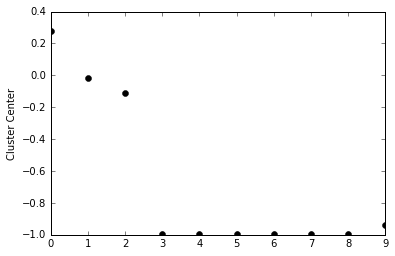

In [24]:
idmax = np.argmax(df['laying'])

plot(centers[idmax,:10], 'ok')
ylabel('Cluster Center');

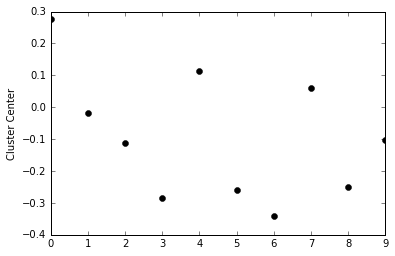

In [25]:
idmax = np.argmax(df['walk'])

plot(centers[idmax,:10], 'ok')
ylabel('Cluster Center');